### Installing neccessary packages:

In [1]:
!pip install transformers
# https://huggingface.co/transformers/installation.html
!pip install sentencepiece
# https://pypi.org/project/sentencepiece/
# Python wrapper for SentencePiece. This API will offer the encoding, decoding and training of Sentencepiece.
!pip install Cython
# https://pypi.org/project/Cython/

     |████████████████████████████████| 3.1 MB 11.8 MB/s 
     |████████████████████████████████| 61 kB 328 kB/s 
     |████████████████████████████████| 895 kB 40.0 MB/s 
     |████████████████████████████████| 3.3 MB 28.1 MB/s 
     |████████████████████████████████| 596 kB 36.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 11.2 MB/s 


## Checking the GPU availabilty

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the required packages:

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [22]:
import os
import sys
from transformers.optimization import Adafactor 
import time
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import torch
import random
import re

os.chdir('/content/drive/MyDrive/Colab Notebooks/new_run_10_odd')

In [78]:
import pandas as pd
# Reading csv
data = pd.read_csv('data_10_full_v1.csv')
print(data.head(5))
data_ood = pd.read_csv('10_5digits_ood_v1.csv')
print(data_ood.head(5))

                                              inputs  ... sumlen
0  The sum of 1 1000 4 100 0 10 6 and 7 100 2 10 ...  ...      4
1  The sum of 1 1000 6 100 1 10 6 and 1 1000 1 10...  ...      4
2  The sum of 3 100 7 10 6 and 1 1000 6 100 1 10 ...  ...      4
3  The sum of 1 1000 0 100 3 10 1 and 4 100 9 10 ...  ...      4
4  The sum of 1 1000 3 100 6 10 3 and 5 100 2 10 ...  ...      4

[5 rows x 5 columns]
                                              inputs  ... sumlen
0  The sum of 1 10000 8 1000 9 100 7 10 6 and 1 1...  ...      5
1  The sum of 2 10000 8 1000 6 100 2 10 6 and 1 1...  ...      5
2  The sum of 2 10000 6 1000 2 100 7 10 8 and 2 1...  ...      5
3  The sum of 1 10000 8 1000 7 100 2 10 3 and 1 1...  ...      5
4  The sum of 2 10000 9 1000 4 100 3 10 6 and 3 1...  ...      5

[5 rows x 5 columns]


In [79]:
data.info

<bound method DataFrame.info of                                                   inputs  ... sumlen
0      The sum of 1 1000 4 100 0 10 6 and 7 100 2 10 ...  ...      4
1      The sum of 1 1000 6 100 1 10 6 and 1 1000 1 10...  ...      4
2      The sum of 3 100 7 10 6 and 1 1000 6 100 1 10 ...  ...      4
3      The sum of 1 1000 0 100 3 10 1 and 4 100 9 10 ...  ...      4
4      The sum of 1 1000 3 100 6 10 3 and 5 100 2 10 ...  ...      4
...                                                  ...  ...    ...
14964       The sum of 9 100 8 10 1 and 6 100 9 10 8 is   ...      4
14965  The sum of 1 1000 3 100 0 10 0 and 6 100 5 10 ...  ...      4
14966  The sum of 1 1000 6 100 6 10 0 and 8 100 8 10 ...  ...      4
14967  The sum of 5 100 7 10 3 and 1 1000 0 100 0 10 ...  ...      4
14968  The sum of 4 100 9 10 6 and 1 1000 7 100 3 10 ...  ...      4

[14969 rows x 5 columns]>

In [80]:
data = data.sample(n = 11700, random_state = 42).reset_index(drop=True)
len(data)
data_extra_ood = data_ood.sample(n = 1300, random_state = 42).reset_index(drop=True)
len(data_extra_ood)

1300

In [81]:
data = data.append(data_extra_ood, ignore_index=True)

In [82]:
from sklearn.model_selection import train_test_split

# Test and validation split
train, validation = train_test_split(data, test_size=0.2, random_state=42)
train, test = train_test_split(train, test_size=0.3, random_state=42)

data_train = train.reset_index(drop=True)
data_valid = validation.reset_index(drop=True)
data_test = test.reset_index(drop=True)

In [83]:
data_train.shape

(7280, 5)

In [84]:
data_valid.shape

(2600, 5)

In [85]:
data_test.shape

(3120, 5)

In [86]:
# Initializing Parameters 
batch_size, num_of_epochs = 32, 25
num_of_batches = int(len(data_train)/batch_size)

In [87]:
# Reference
# https://huggingface.co/transformers/model_doc/t5.html
# https://medium.com/analytics-vidhya/t5-a-detailed-explanation-a0ac9bc53e51
# https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45

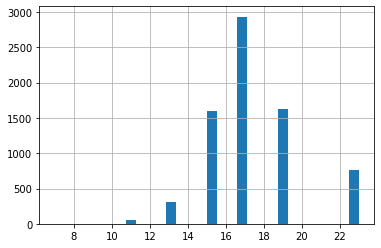

In [88]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_train['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [89]:
# T5-base
tokenizer = T5Tokenizer.from_pretrained('t5-base')

model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
# moving the model to device(GPU/CPU)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [90]:
token_lens = []

for txt in data_train.inputs:
  # doubt
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

max(token_lens)

30

In [91]:
token_lens_target = []

for txt in data_train.target:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_target.append(len(tokens))

max(token_lens_target)

13

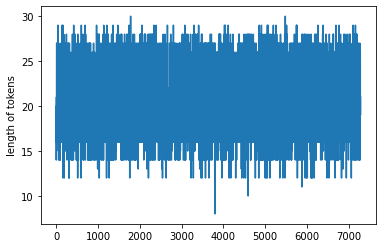

Maximum length is:  30


In [92]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)
# when sample with first 40k and last 40k we got the maximum length is 14

In [93]:
MAX_LEN = 30

In [94]:
def get_word_embeddings(data, MAX_LEN=45):
  input_ids=[]
  attention_masks = []
  for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

In [95]:
# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = get_word_embeddings(data_train['inputs'])
val_inputs, val_masks = get_word_embeddings(data_valid['inputs'])
test_inputs, test_masks = get_word_embeddings(data_test['inputs'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [96]:
data_train['target_str'] = data_train['target'].astype(str)
data_valid['target_str'] = data_valid['target'].astype(str)
data_test['target_str'] = data_test['target'].astype(str)


In [97]:
#convert lists to tensors
train_labels = get_word_embeddings(data_train['target_str'], 20)[0]
val_labels = get_word_embeddings(data_valid['target_str'], 20)[0]
test_labels = get_word_embeddings(data_test['target_str'], 20)[0]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [98]:
train_labels.shape
# doubt

torch.Size([7280, 20])

In [99]:
train_labels

tensor([[ 505,  910,  204,  ...,    0,    0,    0],
        [ 209, 5580,  431,  ...,    0,    0,    0],
        [ 204, 5580,  314,  ...,    0,    0,    0],
        ...,
        [ 209, 5580,  220,  ...,    0,    0,    0],
        [ 220, 5580,  305,  ...,    0,    0,    0],
        [ 220, 5580,  489,  ...,    0,    0,    0]])

In [100]:
data_train['target']

0              8 100 2 10 2
1       1 1000 6 100 2 10 6
2       2 1000 4 100 0 10 5
3              1 100 6 10 3
4       1 1000 0 100 8 10 7
               ...         
7275    2 1000 8 100 5 10 9
7276    1 1000 6 100 2 10 4
7277    1 1000 3 100 3 10 7
7278    3 1000 5 100 1 10 8
7279    3 1000 7 100 2 10 1
Name: target, Length: 7280, dtype: object

In [101]:
train_inputs.shape

torch.Size([7280, 45])

In [102]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [103]:
#  Optimizer
# https://huggingface.co/transformers/model_doc/t5.html#overview
optimizer = Adafactor(
    model.parameters(),
    lr=5e-4, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.3,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [104]:
# Changing the directory to store the model there.
# print(os.getcwd())
# os.chdir('/content/drive/MyDrive/Colab Notebooks/new_run')
# print(os.getcwd())

In [105]:
# Loading the configuration file for 't5-base' model
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2021-12-05 00:42:49--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.214
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json.2’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2021-12-05 00:42:49 (54.5 MB/s) - ‘t5-base-config.json.2’ saved [1199/1199]



In [54]:
from IPython.display import HTML, display

# Setting the progress, with html as UI.
def progress(loss, value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [55]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    v_accuracy = []
    v_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        
        v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in batch)

        # print(v_input_ids.shape, v_labels.shape)

        val_outputs = model.generate(input_ids=v_input_ids, attention_mask=v_attn_mask)

        val_preds = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in val_outputs]

        val_labels = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in v_labels]
        
        # v_loss.append(val_outputs.loss)

        # Get the predictions
        # print(val_outputs.logits.shape)
        # val_preds = torch.argmax(val_outputs.logits, dim=1).flatten()
        # print(val_preds, val_labels)
        # Calculate the accuracy rate

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        accuracy = ((val_preds == val_labels).sum() / len(val_labels)) * 100
        v_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    # v_loss = np.mean(v_loss)
    v_accuracy = np.mean(v_accuracy)

    return v_accuracy

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  running_loss=0
  # out = display(progress(1, num_of_batches+1), display_id=True)
  i =0 
  for batch in train_dataloader:
    
    input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()
    gc.collect()
    torch.cuda.empty_cache()

    # Forward propogation
    # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
    outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
    
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    # out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    # updating the params
    optimizer.step()

    print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader), " Training Loss ", loss_num)
    i += 1

  running_loss = running_loss/len(train_dataloader)
  # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
  curr_accuracy = evaluate(model, val_dataloader)

  # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
  print("-"*70)

  if curr_accuracy > val_acc:
    val_acc = curr_accuracy
    # Saving the best model
    torch.save(model.state_dict(),'Fine_tune_10based_model_v2_with_10per_ood.bin')


Streaming output truncated to the last 5000 lines.
Epoch  4 Batch  81 / 228  Training Loss  0.006206437945365906
Epoch  4 Batch  82 / 228  Training Loss  0.007809885777533054
Epoch  4 Batch  83 / 228  Training Loss  0.0061338008381426334
Epoch  4 Batch  84 / 228  Training Loss  0.005070612300187349
Epoch  4 Batch  85 / 228  Training Loss  0.008318006061017513
Epoch  4 Batch  86 / 228  Training Loss  0.016389505937695503
Epoch  4 Batch  87 / 228  Training Loss  0.009210653603076935
Epoch  4 Batch  88 / 228  Training Loss  0.007397035602480173
Epoch  4 Batch  89 / 228  Training Loss  0.023871934041380882
Epoch  4 Batch  90 / 228  Training Loss  0.02265647053718567
Epoch  4 Batch  91 / 228  Training Loss  0.004307321272790432
Epoch  4 Batch  92 / 228  Training Loss  0.004547972232103348
Epoch  4 Batch  93 / 228  Training Loss  0.0026716955471783876
Epoch  4 Batch  94 / 228  Training Loss  0.0089536402374506
Epoch  4 Batch  95 / 228  Training Loss  0.008177082054316998
Epoch  4 Batch  96 /

In [ ]:
# Changing the directory to store the model there.
# print(os.getcwd())
# os.chdir('/content/drive/My Drive/Colab Notebooks/new/')
# print(os.getcwd())

#### Saving the Model (creating checkpoint)

In [ ]:
# PATH = "fine_tune_10e_25eph.pt"
# torch.save({
#             'epoch': num_of_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': running_loss,
#             }, PATH)

In [48]:
model_load = T5ForConditionalGeneration.from_pretrained('Fine_tune_10based_model_v2_with_10per_ood.bin', return_dict=True, config='t5-base-config.json')

In [57]:
model_load.to(device)
evaluate(model_load, test_dataloader)

99.26658163265306

In [58]:
model_load.to('cpu')
# evaluate(model_load, test_dataloader)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [59]:
model_load.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [60]:
# Function to generate sentences from symptoms on the test dataset
def generateText(text):
  model_load.eval()
  input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
  # s = time.time()
  outputs = model_load.generate(input_ids)
  prediction=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  return prediction

In [61]:
model_load.device

device(type='cpu')

In [62]:
data_valid
# testing on this for now

,inputs,target,maxlen,minlen,sumlen,target_str
0,The sum of 1 1000 2 100 7 10 9 and 1 1000 8 10...,3 1000 1 100 6 10 9,4,4,4,3 1000 1 100 6 10 9
1,The sum of 4 100 8 10 0 and 1 1000 8 100 1 10 ...,2 1000 2 100 9 10 0,4,3,4,2 1000 2 100 9 10 0
2,The sum of 3 100 2 10 7 and 1 1000 2 100 1 10 ...,1 1000 5 100 4 10 1,4,3,4,1 1000 5 100 4 10 1
3,The sum of 1 1000 4 100 6 10 0 and 4 100 0 10 ...,1 1000 8 100 6 10 8,4,3,4,1 1000 8 100 6 10 8
4,The sum of 1 1000 8 100 1 10 8 and 1 1000 1 10...,2 1000 9 100 3 10 1,4,4,4,2 1000 9 100 3 10 1
...,...,...,...,...,...,...
2595,The sum of 2 10000 5 1000 4 100 3 10 6 and 1 1...,4 10000 3 1000 4 100 0 10 8,5,5,5,4 10000 3 1000 4 100 0 10 8
2596,The sum of 2 100 6 10 3 and 5 100 6 10 6 is,8 100 2 10 9,3,3,3,8 100 2 10 9
2597,The sum of 1 1000 9 100 8 10 7 and 1 100 9 10 ...,2 1000 1 100 8 10 1,4,3,4,2 1000 1 100 8 10 1
2598,The sum of 1 1000 5 100 7 10 6 and 5 100 8 10 ...,2 1000 1 100 5 10 6,4,3,4,2 1000 1 100 5 10 6


In [63]:
generateText(data_valid.inputs[0])

' 3 1000 1 100 6 10 9'

In [106]:
# data_ood = pd.read_csv('data_10_ood_full.csv')
print(data_ood.head(5), data_ood.shape)

                                              inputs  ... sumlen
0  The sum of 1 10000 8 1000 9 100 7 10 6 and 1 1...  ...      5
1  The sum of 2 10000 8 1000 6 100 2 10 6 and 1 1...  ...      5
2  The sum of 2 10000 6 1000 2 100 7 10 8 and 2 1...  ...      5
3  The sum of 1 10000 8 1000 7 100 2 10 3 and 1 1...  ...      5
4  The sum of 2 10000 9 1000 4 100 3 10 6 and 3 1...  ...      5

[5 rows x 5 columns] (15000, 5)


In [107]:
data_ood = data_ood.sample(n = 6000, random_state = 42).reset_index(drop=True)

In [108]:
data_ood['type'] = "OOD"

In [109]:
data_test['type'] = 'iid'
data_ood['target_str'] = data_ood['target'].astype(str)

In [74]:
data_full = data_ood + data_test


In [110]:
bigdata = data_test.append(data_ood, ignore_index=True)

In [111]:
bigdata

,inputs,target,maxlen,minlen,sumlen,target_str,type
0,The sum of 1 1000 3 100 4 10 5 and 1 1000 2 10...,2 1000 6 100 0 10 6,4,4,4,2 1000 6 100 0 10 6,iid
1,The sum of 1 1000 5 100 2 10 0 and 1 1000 5 10...,3 1000 1 100 0 10 7,4,4,4,3 1000 1 100 0 10 7,iid
2,The sum of 1 10 2 and 1 1000 5 100 2 10 3 is,1 1000 5 100 3 10 5,4,2,4,1 1000 5 100 3 10 5,iid
3,The sum of 3 100 3 10 7 and 4 100 1 10 3 is,7 100 5 10 0,3,3,3,7 100 5 10 0,iid
4,The sum of 2 100 5 10 2 and 1 1000 1 100 2 10 ...,1 1000 3 100 8 10 0,4,3,4,1 1000 3 100 8 10 0,iid
...,...,...,...,...,...,...,...
9115,The sum of 2 10000 9 1000 5 100 6 10 5 and 2 1...,5 10000 0 1000 9 100 8 10 7,5,5,5,5 10000 0 1000 9 100 8 10 7,OOD
9116,The sum of 3 10000 4 1000 8 100 0 10 0 and 3 1...,6 10000 5 1000 1 100 2 10 3,5,5,5,6 10000 5 1000 1 100 2 10 3,OOD
9117,The sum of 3 10000 4 1000 3 100 4 10 1 and 1 1...,5 10000 0 1000 4 100 0 10 4,5,5,5,5 10000 0 1000 4 100 0 10 4,OOD
9118,The sum of 2 10000 8 1000 0 100 7 10 6 and 3 1...,6 10000 4 1000 6 100 0 10 2,5,5,5,6 10000 4 1000 6 100 0 10 2,OOD


In [112]:
bigdata.describe()

,maxlen,minlen,sumlen
count,9120.000000,9120.000000,9120.000000
mean,4.612061,4.423794,4.653070
std,0.628793,0.921234,0.549583
min,2.000000,1.000000,2.000000
25%,4.000000,4.000000,4.000000
50%,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000


In [ ]:
bigdata['predictions'] = bigdata.apply(lambda x: generateText(x['inputs']), axis=1)
bigdata.to_csv('results_prediction.csv', index = False, header=None)

Don't execute from below.

In [ ]:
bigdata

,inputs,target,maxlen,minlen,sumlen,target_str,type,predictions
0,The sum of 1 1000 3 100 4 10 5 and 1 1000 2 10...,2 1000 6 100 0 10 6,4,4,4,2 1000 6 100 0 10 6,iid,2 1000 6 100 0 10 6
1,The sum of 1 1000 5 100 2 10 0 and 1 1000 5 10...,3 1000 1 100 0 10 7,4,4,4,3 1000 1 100 0 10 7,iid,3 1000 1 100 0 10 7
2,The sum of 1 10 2 and 1 1000 5 100 2 10 3 is,1 1000 5 100 3 10 5,4,2,4,1 1000 5 100 3 10 5,iid,1 1000 5 100 3 10 5
3,The sum of 3 100 3 10 7 and 4 100 1 10 3 is,7 100 5 10 0,3,3,3,7 100 5 10 0,iid,7 100 5 10 0
4,The sum of 2 100 5 10 2 and 1 1000 1 100 2 10 ...,1 1000 3 100 8 10 0,4,3,4,1 1000 3 100 8 10 0,iid,1 1000 3 100 8 10 0
...,...,...,...,...,...,...,...,...
11067,The sum of 5 100 8 10 1 and 5 100 1 10 1 is,1 1000 0 100 9 10 2,3,3,4,1 1000 0 100 9 10 2,OOD,1 1000 0 100 9 10 2
11068,The sum of 1 100 9 10 5 and 6 100 7 10 3 is,8 100 6 10 8,3,3,3,8 100 6 10 8,OOD,8 100 6 10 8
11069,The sum of 1 100 8 10 4 and 2 100 3 10 6 is,4 100 2 10 0,3,3,3,4 100 2 10 0,OOD,4 100 2 10 0
11070,The sum of 3 100 4 10 2 and 9 100 0 10 7 is,1 1000 2 100 4 10 9,3,3,4,1 1000 2 100 4 10 9,OOD,1 1000 2 100 4 10 9


In [ ]:
lest = []
same_ = []
for i, j, isood in zip(bigdata['target_str'], bigdata['predictions'], bigdata['type']):
  if i.strip() != j.strip():
    lest.append((i, j, isood))
  else:
    same_.append((i, j, isood))
print(len(lest), len(same_))

57 11015


In [ ]:
lest

[('1 1000 1 100 9 10 9', ' 1 1000 2 100 9 10 9', 'iid'),
 ('5 100 0 10 0', ' 4 100 0 10 0', 'iid'),
 ('1 1000 9 100 2 10 9', ' 1 1000 9 100 3 10 9', 'iid'),
 ('8 100 9 10 8', ' 9 100 9 10 8', 'iid'),
 ('2 1000 3 100 9 10 9', ' 2 1000 4 100 9 10 9', 'iid'),
 ('1 1000 8 100 5 10 7', ' 1 1000 8 100 5 10 8', 'iid'),
 ('8 100 9 10 1', ' 9 100 9 10 1', 'OOD'),
 ('3 100 0 10 1', ' 2 100 0 10 1', 'OOD'),
 ('5 10 6', ' 6 10 6', 'OOD'),
 ('8 100 9 10 9', ' 9 100 9 10 9', 'OOD'),
 ('9 100 9 10 5', ' 1 1000 0 100 9 10 5', 'OOD'),
 ('1 100 4 10 5', ' 1 1000 4 10 5', 'OOD'),
 ('6 100 0 10 7', ' 5 100 0 10 7', 'OOD'),
 ('8 10 7', ' 9 10 7', 'OOD'),
 ('3 100 0 10 1', ' 2 100 0 10 1', 'OOD'),
 ('4 100 0 10 0', ' 3 100 0 10 0', 'OOD'),
 ('8 10 9', ' 9 10 9', 'OOD'),
 ('2 100 1 10 3', ' 2 100 0 10 3', 'OOD'),
 ('8 100 9 10 7', ' 9 100 9 10 7', 'OOD'),
 ('8 100 9 10 8', ' 9 100 9 10 8', 'OOD'),
 ('5 10 7', ' 6 10 7', 'OOD'),
 ('1 100 2 10 2', ' 1 1000 2 10 2', 'OOD'),
 ('8 100 9 10 9', ' 9 100 9 10 9', 'O

In [ ]:
def convert_to_10ebased(number: str, split_type: str, invert_number: bool) -> str:
    signal = None
    if number[0] == '-':
        signal = '-'
        number = number[1:]

    output = []
    for i, digit in enumerate(number[::-1]):
        if split_type is None:
            output.append('10e' + str(i))
        elif split_type == 'underscore':
            output.append('10e' + '_'.join(str(i)))
        elif split_type == 'character':
            output.append(' '.join('D' + str(i) + 'E'))
        else:
            raise Exception(f'Wrong split_type: {split_type}')
        output.append(digit)

    if signal:
        output.append(signal)

    # The output is already inverted. If we want it to _not_ be inverted, then we invert it.
    if not invert_number:
        output = output[::-1]

    return ' '.join(output)

In [ ]:
def convert_to_10based(number: str, invert_number: bool) -> str:
    signal = None
    if number[0] == '-':
        signal = '-'
        number = number[1:]

    output = []
    for i, digit in enumerate(number[::-1]):
        if i > 0:
            output.append('1' + i * '0')
        output.append(digit)

    if signal:
        output.append(signal)

    # The output is already inverted. If we want it to not be inverted, then we invert it.
    if not invert_number:
        output = output[::-1]

    return ' '.join(output)

In [ ]:
convert_to_10ebased(
                "932", split_type=None, invert_number=False)

'9 10e2 3 10e1 2 10e0'

Testing with OOD

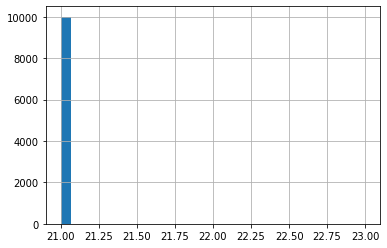

In [ ]:
seq_len = [len(i.split()) for i in data_ood['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
token_lens_ood = []

for txt in data_ood.inputs:
  # doubt
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_ood.append(len(tokens))

max(token_lens_ood)

46

In [ ]:
token_lens_target_ood = []

for txt in data_ood.target:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_target_ood.append(len(tokens))

max(token_lens_target_ood)

24

In [ ]:
ood_inputs, ood_masks = get_word_embeddings(data_ood['inputs'], 55)
data_ood['target_str'] = data_ood['target'].astype(str)
ood_labels = get_word_embeddings(data_ood['target_str'], 30)[0]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
ood_data = TensorDataset(ood_inputs, ood_masks, ood_labels)
ood_dataloader = DataLoader(ood_data, shuffle = True, batch_size = batch_size)